In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

Softmax回归的输出层是一个全连接层

In [2]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

# 定义权重初始化函数
def init_weights(m):
    # 检查当前模块m的类型是否为线性层（全连接层）
    if type(m) == nn.Linear:
        # 如果是线性层，使用正态分布初始化权重
        # mean=0（默认），std=0.01（标准差为0.01）
        nn.init.normal_(m.weight, std=0.01)

# 将初始化函数应用到网络的所有模块上
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数

In [3]:
loss = nn.CrossEntropyLoss()

使用学习率为0.1的小批量随机梯度下降作为优化算法

In [4]:
trainer = torch.optim.SGD(net.parameters(),lr=0.1)

调用之前定义的训练函数来训练模型

In [5]:
# 1. 添加缺失的准确率计算函数
def accuracy(y_hat, y):  
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 获取最大概率对应的类别
    cmp = y_hat.type(y.dtype) == y   # 比较预测值和真实值
    return float(cmp.type(y.dtype).sum())  # 返回正确预测的数量

def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
    
# 2. 先定义缺失的工具类和函数
class Accumulator:  # 定义一个累加器类，用于统计多个数值
    """在n个变量上累加"""  # 类的文档字符串，说明这个类的用途
    
    def __init__(self, n):  # 构造函数，n表示要累加几个变量
        self.data = [0.0] * n  # 创建一个长度为n的列表，所有元素初始化为0.0
        # 例如：n=2时，self.data = [0.0, 0.0]
    
    def add(self, *args):  # 添加方法，*args表示可以接收任意数量的参数
        # zip(self.data, args) 将self.data和args中的元素一一配对
        # a + float(b) 将对应位置的数值相加（b转换为浮点数）
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # 列表推导式：遍历配对的元素，将它们相加后生成新列表
    
    def reset(self):  # 重置方法，将所有累加值清零
        self.data = [0.0] * len(self.data)  # 重新创建全零列表
    
    def __getitem__(self, idx):  # 魔法方法，允许用索引访问：accumulator[0]
        return self.data[idx]  # 返回指定索引位置的值

evaluate_accuracy(net, test_iter)

# 3. 可视化类
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
# 4. 训练函数
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)  # 训练损失总和、训练准确度总和、样本数
    
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用自定义优化器（暂时不实现）
            updater.zero_grad()
            l.mean().backward()
            updater.step()
            
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

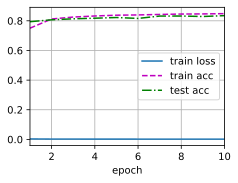

In [6]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

loss函数出不来的原因>Y轴范围设置不当：ylim=[0.3, 0.9] 太小了，损失值通常在1-3之间，而准确率在0-1之间